In [1]:
# Bibliotecas Utilizadas
import seaborn as sns
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import glob as gb
import seaborn as sns
from scipy.signal import find_peaks as fp
from scipy.optimize import curve_fit

In [2]:
sns.set_theme(font_scale = 0.5, context = "poster")


In [13]:
#funções auxiliares

def gaussian(x, a, x0, sigma):
    '''Uma função que a partir dos parâmetros definidos gera a gaussiana'''
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def multi_gaussian(x, *params):
    '''geração de várias gaussianas a partir de vários parâmetros'''
    n = len(params) // 3
    y = np.zeros_like(x)
    for i in range(n):
        a = params[3*i]
        x0 = params[3*i+1]
        sigma = params[3*i+2]
        y += gaussian(x, a, x0, sigma)
    return y

def multi_gaussian_parametros(x, *params):
    '''Associa a cada gaussiana o seu parâmetro'''
    indice = 1
    n = len(params) // 3
    y = np.zeros_like(x)
    for i in range(n):
        a = params[3*i]
        x0 = params[3*i+1]
        sigma = params[3*i+2]
        y += gaussian(x, a, x0, sigma)
        
        print(f"Parametros da gaussiana {indice}: altura máxima {indice} = {round(a,3)} em abs, comprimento de onda do pico {indice} = {round(x0,3)} nm, FWHM {indice} = {round(sigma,3)}")
        indice += 1

def achar_picos_chato (file_pattern, x_min = 0 , x_max = float("inf"), h = 0, dist = None):
    """Faz uma tabela com os picos de absorbância com seus respectivos comproimentos de onda. Não plota um gráfico sinalizando esses picos!"""
    arquivos = gb.glob(file_pattern)
    indice = 1
    for i in arquivos: 
        dados = pd.read_csv(i)
        dados.rename(columns = {dados.columns[0]: "Comprimento de onda (nm)", dados.columns[1]: "Absorbância"}, inplace = True)
        
        comprimento_de_onda = dados["Comprimento de onda (nm)"].values
        
        dados_filtrados = dados[(dados["Comprimento de onda (nm)"] >= x_min) & (dados["Comprimento de onda (nm)"] <= x_max)]
        
        comprimento_de_onda = dados_filtrados["Comprimento de onda (nm)"].values
        absorbancia = dados_filtrados["Absorbância"].values
 
    prom = None

    p, _ = fp(x = dados_filtrados.Absorbância,
              height = h,
              prominence = prom,
              distance = dist
              )
   
    return dados_filtrados.iloc[p]

def lista_picos (file_pattern, x_min, x_max, h, dist):
    '''Gera uma lista com os picos com base na função acha picos'''
    h = 0.3
    a = achar_picos_chato (file_pattern, x_min, x_max, h, dist)
    c = a.values.tolist()
    known_peaks = []
    for i,v in enumerate(c):
        known_peaks.append (c[i][0])
    return known_peaks
    




In [14]:
def plt_gaussianas(file_pattern, x_min = 0, x_max = float('inf'), h = 0, dist = None, title = ''):
    '''Plota o gráfico da função'''

#Ajustando o nome das colunas do arquivo
    data = pd.read_csv(file_pattern)

    data.rename(columns = {data.columns[0]: "Comprimento de onda (nm)", data.columns[1]: "Absorbância"}, inplace = True)

    wavelengths = data["Comprimento de onda (nm)"]

    absorbance = data["Absorbância"]
    
    known_peaks=lista_picos(file_pattern,x_min,x_max,h,dist)
# Suposição inicial para os parâmetros da gaussianas: [a1, x0_1, sigma1, a2, x0_2, sigma2, ...]

    initial_guesses = []
    for peak in known_peaks:
        a_guess = max(absorbance)  # Initial guess for amplitude
        sigma_guess = 20  # Initial guess for width
        initial_guesses.extend([a_guess, peak, sigma_guess])

    popt, _ = curve_fit(multi_gaussian, wavelengths, absorbance, p0=initial_guesses)

    plt.plot(wavelengths, absorbance, label='Data')

# Plot da função multi-Gaussiana ajustada
    fitted_absorbance = multi_gaussian(wavelengths, *popt)
    multi_gaussian_parametros(wavelengths, *popt)
    
    plt.plot(wavelengths, fitted_absorbance, label='Fitted Multi-Gaussian', linestyle='--')

# Plot de cada individual comportamento da gaussiana
    for i in range(len(popt) // 3):
        a = popt[3*i]
        x0 = popt[3*i+1]
        sigma = popt[3*i+2]
        plt.plot(wavelengths, gaussian(wavelengths, a, x0, sigma), linestyle=':', label=f'Gaussian {i+1}')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.title(f"{title} - Deconvolução gaussiana")
    
    plt.legend()

    plt.savefig(f"{title} - Deconvolução gaussiana.png")
    plt.show()

Parametros da gaussiana 1: altura máxima 1 = 3.909 em abs, comprimento de onda do pico 1 = 211.724 nm, FWHM 1 = 13.734
Parametros da gaussiana 2: altura máxima 2 = 0.825 em abs, comprimento de onda do pico 2 = 439.563 nm, FWHM 2 = 96.469


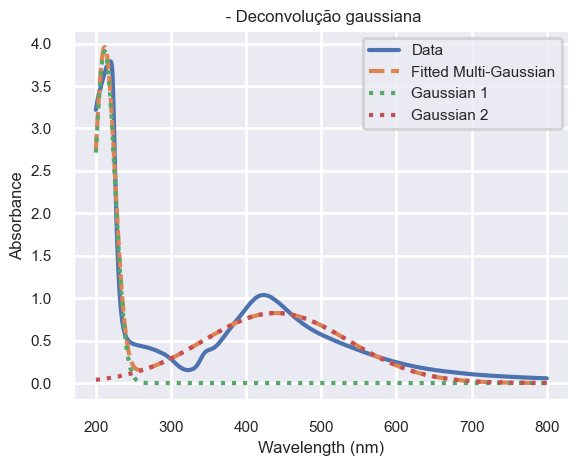

In [15]:
plt_gaussianas ('Andriel_Rafa_1UVvis_sintese1.txt')